In [1]:
from torch import nn
import pandas as pd
import sqlite3
import torch
from torch import Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from tqdm import tqdm
import math
import numpy as np
import numpy as np
import pandas as pd
import sqlite3
import json
import math
import torch
import matplotlib.pyplot as plt
from dataclasses import dataclass
from torch_geometric.data import Data, InMemoryDataset
from sklearn.preprocessing import MinMaxScaler
from torchinfo import summary
import seaborn as sns
import os
import joblib
from simple_diffusion import Noiser, ImprovedNoiser, DDPMTrainer, ClimbDDPM, ClimbDDPMGenerator, clear_compile_keys
from climb_conversion import ClimbsFeatureArray, ClimbsFeatureScaler

In [ ]:
sum([p.numel() for p in ClimbDDPM(model=Noiser(hidden_dim=128, layers=5)).parameters()])

In [ ]:
#Test single-batch memorization to ensure both model architectures are working properly.
def test_single_batch(model: nn.Module, dataset: TensorDataset, steps: int = 1000, lr = 1e-3, decay=0.0):
    if decay == 0:
        optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
    else:
        optimizer = torch.optim.AdamW(params = model.parameters(), lr=lr, weight_decay=decay)

    loader = DataLoader(dataset=dataset, batch_size=64)
    x, c = next(iter(loader))
    losses = []
    with tqdm(range(steps)) as pbar:
        for epoch in pbar:
            optimizer.zero_grad()
            loss = model.loss(x, c)
            loss.backward()
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            losses.append(loss.item())
            if epoch % 10 == 0:
                pbar.set_postfix_str(f"Loss: {loss.item():.4f}, Improvement:{losses[-1]-loss.item():.4f}, Grad Norm:{grad_norm:.4f}, Min loss:{min(losses) if len(losses) > 0 else 0:.5f}")
    print(f"Min loss:{min(losses):.5f}")
    return losses

def moving_average(values, window, gaussian = False):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    #We create the vector to multiply each value by to get the moving average. Essentially a vector of length n
    # in which each weight is 1/n.
    kernel = np.repeat(1.0, window) / window
    if (gaussian == True) :
        if window % 2 == 0:
            window+=1
        x = np.arange(-(window // 2), window // 2 + 1)
        kernel = np.exp(-(x ** 2) / (2 * window ** 2))
        kernel = kernel / np.sum(kernel)
    
    #The convolve function iteratively multiplies the first n values in the values array by the weights array.
    # with the given weights array, it essentially takes the moving average of each N values in the values array.
    return np.convolve(values, kernel, "valid")

In [ ]:
losses1 = test_single_batch(ClimbDDPM(Noiser(), predict_noise=True),TensorDataset(*dataset))
losses2 = test_single_batch(ClimbDDPM(ImprovedNoiser(128), predict_noise=True),TensorDataset(*dataset))

#With LR Scheduler
l1 = moving_average(losses1, 50)
l2 = moving_average(losses2, 50)

fig, ax = plt.subplots(1,1,figsize=(8,8))

ax.plot(list(range(len(l1))), l1, label=f"Losses U-Net{sum([p.numel() for p in Noiser().parameters()])}")
ax.plot(list(range(len(l2))), l2, label=f"Losses Self-Attention({sum([p.numel() for p in ImprovedNoiser(128).parameters()])})")
ax.set_yscale('log')
ax.legend()
plt.show()

In [ ]:
losses1 = test_single_batch(ClimbDDPM(Noiser(sinusoidal=True), predict_noise=True),TensorDataset(*dataset))
losses2 = test_single_batch(ClimbDDPM(Noiser(), predict_noise=True),TensorDataset(*dataset))

#With LR Scheduler
l1 = moving_average(losses1, 50)
l2 = moving_average(losses2, 50)

fig, ax = plt.subplots(1,1,figsize=(8,8))

ax.plot(list(range(len(l1))),l1, label="Losses Sinusoidal Emb")
ax.plot(list(range(len(l2))), l2, label="Losses Linear Emb")
ax.set_yscale('log')
ax.legend()
plt.show()

In [ ]:
losses1 = test_single_batch(ClimbDDPM(Noiser(), predict_noise=True),TensorDataset(*dataset))
losses2 = test_single_batch(ClimbDDPM(ImprovedNoiser(), predict_noise=True),TensorDataset(*dataset), decay=1e-4)

# Without LR Scheduler
l1 = moving_average(np.array(losses1), 50)
l2 = moving_average(np.array(losses2), 50)

fig, ax = plt.subplots(1,1,figsize=(8,8))

ax.plot(list(range(len(l1))), l1, label=f"Losses No Weight Decay")
ax.plot(list(range(len(l2))), l2, label=f"Losses Weight Decay")
ax.set_yscale('log')
ax.legend()
plt.show()

In [ ]:
climbs = ClimbsFeatureArray('../data/storage.db')
dataset = climbs.get_features(limit = 10000, augment_reflections=False)
losses1 = test_single_batch(ClimbDDPM(Noiser(sinusoidal=False), predict_noise=True),TensorDataset(*dataset))
losses2 = test_single_batch(ClimbDDPM(Noiser(), predict_noise=True),TensorDataset(*dataset))

# Without LR Scheduler
l1 = moving_average(np.array(losses1), 50)
l2 = moving_average(np.array(losses2), 50)

fig, ax = plt.subplots(1,1,figsize=(8,8))

ax.plot(list(range(len(l1))), l1, label=f"Losses w. Weight Decay ({sum([p.numel() for p in Noiser().parameters()])} params)")
ax.plot(list(range(len(l2))), l2, label=f"Losses w0. Weight Decay (lr=.001, {sum([p.numel() for p in Noiser().parameters()])} params)")
ax.set_yscale('log')
ax.legend()
plt.show()

In [ ]:
# Test Sinusoidal Embedding on a medium-sized dataset.
climbs = ClimbsFeatureArray('../data/storage.db')
dataset = climbs.get_features(limit = 2000, augment_reflections=True)
losses1 = test_single_batch(ClimbDDPM(Noiser(128), predict_noise=True),TensorDataset(*dataset), steps=3000)
losses2 = test_single_batch(ClimbDDPM(Noiser(128, sinusoidal=True), predict_noise=True),TensorDataset(*dataset), steps=3000)

# Without LR Scheduler
l1 = moving_average(np.array(losses1), 50)
l2 = moving_average(np.array(losses2), 50)

fig, ax = plt.subplots(1,1,figsize=(8,8))

ax.plot(list(range(len(l1))), l1, label=f"Losses w. Linear Emb ({sum([p.numel() for p in Noiser(128).parameters()])} params)")
ax.plot(list(range(len(l2))), l2, label=f"Losses w. Sinusoidal Emb ({sum([p.numel() for p in Noiser(128).parameters()])} params)")
ax.set_yscale('log')
ax.legend()
plt.show()

In [19]:
class ClimbDASD(nn.Module):
    def __init__(self, hidden_dim=128, layers=3, sinusoidal=False):
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.timesteps = 100
        self.model = Noiser(hidden_dim,layers, feature_dim=9, sinusoidal=sinusoidal)
        self.roles_head = nn.Softmax(dim=2)

    def _cos_alpha_bar(self, t: Tensor)-> Tensor:
        t = t.view(-1,1,1)
        epsilon = 0.0004
        return  torch.cos((t+epsilon)/(1+2*epsilon)*torch.pi/2)**2
        
    def predict(self, noisy, cond, t):
        """Return prediction for noise."""
        pred = self.model(noisy, cond, t)
        pred_noise = pred[:,:,:4]
        pred_roles = self.discrete_features_head(pred[:,:,4:])

        a = self._cos_alpha_bar(t)

        pred_clean_cont = (noisy - torch.sqrt(1-a)*pred_noise)/torch.sqrt(a)

        return pred_clean_cont, pred_roles
    
    def loss(self, clean, cond):
        """Get the model's loss from training on a dataset of clean (denoised) data."""
        B, H, S = clean.shape
        t = torch.round(torch.rand(B, 1, device=self.device), decimals=2)
        x_0 = torch.randn((B, H, S-5))
        noisy = self.forward_diffusion(clean, t, x_0)

        pred = self.model(noisy, cond, t)
        pred_roles = self.roles_head(pred[:,:,4:])
        continuous_loss = F.mse_loss(pred[:,:,:4], x_0[:,:,:4])
        discrete_loss = F.cross_entropy(pred_roles, clean[:,:,4:])

        return continuous_loss + discrete_loss, continuous_loss, discrete_loss
    
    def forward_diffusion(self, clean, t, x_0: Tensor):
        """
        Perform the forward Diffusion process in two stages:
            *Continuous Diffusion over Continuous Features [0:4]
            *Discrete Absorbing State Diffusion over Discrete Features [4:9]
        
        :param clean: Full feature set (4 continuous, 5 discrete roles OH-Encoded)
        :param t: Timestep Tensor
        :param x_0: Optionally include the tensor for the prior 'full-noise' array to use instead of random noise. This makes the generation process deterministic.
        :return: Diffused climbs, conditioned on timestep
        :rtype: Tensor
        """
        cont_feat = clean[:,:,:4]
        disc_feat = clean[:,:,4:]
        a = self._cos_alpha_bar(t)

        diff_cont = torch.sqrt(a)*cont_feat + torch.sqrt(1-a)*(x_0)

        das_mask = (a > torch.rand_like(a)).float()
        diff_disc = disc_feat*das_mask

        return torch.cat([diff_cont,diff_disc],dim=2)
    
    def forward(self, noisy, cond, t):
        return self.predict(noisy, cond, t)

climbs = ClimbsFeatureArray('../data/storage.db')
full_dataset = climbs.get_features(limit=1000, continuous_only=False)
model = ClimbDASD(64,2)
print(sum([p.numel() for p in model.parameters()]))
optimizer = torch.optim.Adam(model.parameters())

batches = DataLoader(TensorDataset(*full_dataset), batch_size=64)
losses = [[], [], []]
x, c = next(iter(batches))

with tqdm(range(1000)) as pbar:
    for epoch in pbar:
        totals = [0, 0, 0]
        optimizer.zero_grad()
        loss, cont, disc = model.loss(x,c)
        loss.backward()
        optimizer.step()
        totals[0]+=loss.item()
        totals[1]+=cont.item()
        totals[2]+=disc.item()
        pbar.set_postfix_str(f"Epoch: {epoch}, Loss: {totals[0]:.2f}, Continuous: {totals[1]:.2f}, Discrete: {totals[2]:.2f}")
        for i in range(3):
            losses[i].append(totals[i])

l = moving_average(losses[0], 25)
l1 = moving_average(losses[1], 25)
l2 = moving_average(losses[2], 25)
fig, ax = plt.subplots()

sns.lineplot(x=np.array(range(len(l))), y=l, ax=ax)
sns.lineplot(x=np.array(range(len(l1))), y=l1, ax=ax)
sns.lineplot(x=np.array(range(len(l2))), y=l2, ax=ax)
ax.set_yscale('log')
plt.show()


606921


AttributeError: 'tuple' object has no attribute 'size'

c:\Users\EvanM\Documents\Projects\GitHub\ml-homewall-climb-generator\model-training\equivariant_projected_diffusion\simple_diffusion.py:679: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experiment

17691012
....................................................................................................

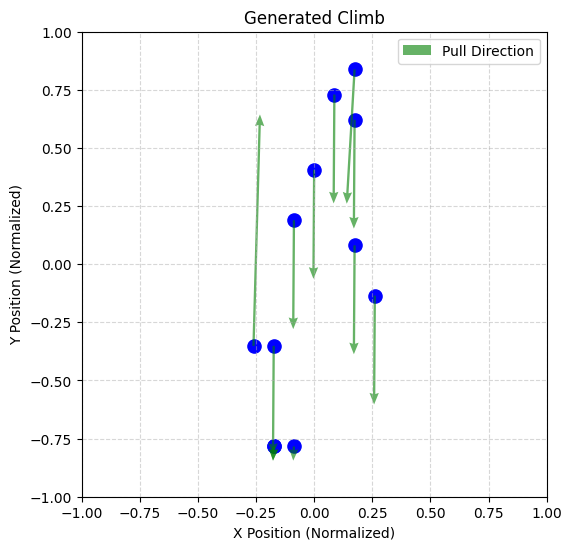

In [94]:
def plot_climb(climb_data, title="Generated Climb"):
    """
    Visualizes a climb generated by a neural network.
    
    Args:
        climb_data (np.array): Shape [20, 4]. 
                               Features: [x, y, pull_x, pull_y, role_emb]
        title (str): Title for the plot.
    """
    # role = np.argmax(climb_data[:,5:], axis=1)
    real_holds = climb_data[climb_data[:,0] > -1.1]
    x, y, pull_x, pull_y = real_holds.T

    # 2. Setup the Plot
    # Climbing walls are vertical, so we use a tall figsize
    fig, ax = plt.subplots(figsize=(6, 8))
    
    # 3. Plot Hand Holds (Circles, Blue)
    # We filter using the inverted boolean mask
    ax.scatter(x, y, c='blue', s=90)

    # 5. Plot Pull Vectors (Arrows)
    # quiver(x, y, u, v) plots arrows at (x,y) with direction (u,v)
    ax.quiver(x, y, pull_x, pull_y, 
              color='green', alpha=0.6, 
              angles='xy', scale_units='xy', scale=1, 
              width=0.005, headwidth=4,
              label='Pull Direction', zorder=1)

    # 6. Formatting
    ax.set_title(title)
    ax.set_xlabel("X Position (Normalized)")
    ax.set_ylabel("Y Position (Normalized)")
    ax.set_ylim(-1,1)
    ax.set_xlim(-1,1)
    
    # Important: set aspect to 'equal' so the wall doesn't look stretched
    ax.set_aspect('equal')
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(loc='upper right')


    plt.show()

class SinusoidalPositionEmbeddings(nn.Module):
    """
    Standard sinusoidal positional embeddings for time steps.
    Helps the model understand 'where' it is in the diffusion process.
    """
    def __init__(self, dim: int = 128):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        # time: (batch_size, 1)
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, 0].unsqueeze(1) * embeddings.unsqueeze(0)
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, cond_dim, padding=1):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=padding)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=padding)
        self.norm1 = nn.GroupNorm(8, out_channels)
        self.norm2 = nn.GroupNorm(8, out_channels)
        self.act = nn.SiLU()

        self.cond_proj = nn.Linear(cond_dim, out_channels*2)
        self.shortcut = nn.Conv1d(in_channels,out_channels,1) if in_channels != out_channels else nn.Identity()

    def forward(self, x, cond):
        h = self.conv1(x)
        h = self.norm1(h)

        gamma, beta = self.cond_proj(cond).unsqueeze(-1).chunk(2, dim=1)
        h = h*(1+gamma) + beta

        h = self.conv2(h)
        h = self.norm2(h)
        h = self.act(h)

        return h + self.shortcut(x)

class Noiser(nn.Module):
    def __init__(self, hidden_dim=128, layers = 5, feature_dim = 4, cond_dim = 4, sinusoidal = True):
        super().__init__()

        self.time_mlp = nn.Sequential(
            (SinusoidalPositionEmbeddings(hidden_dim) if sinusoidal else nn.Linear(1,hidden_dim)),
            nn.Linear(hidden_dim,hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim,hidden_dim)
        )

        self.cond_mlp = nn.Sequential(
            nn.Linear(cond_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
        self.combine_t_mlp = nn.Sequential(
            nn.Linear(hidden_dim*2,hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

        self.init_conv = ResidualBlock1D(feature_dim, hidden_dim, hidden_dim)

        self.down_blocks = nn.ModuleList([ResidualBlock1D(hidden_dim*(i+1), hidden_dim*(i+2), hidden_dim) for i in range(layers)])
        self.up_blocks = nn.ModuleList([ResidualBlock1D(hidden_dim*(i+1), hidden_dim*(i), hidden_dim) for i in range(layers,0,-1)])

        self.head = nn.Conv1d(hidden_dim, feature_dim, 1)
    
    def forward(self, climbs: Tensor, cond: Tensor, t: Tensor)-> Tensor:
        """
        Run denoising pass. Predicts the added noise from the noisy data.
        
        :param climbs: Tensor with hold-set positions. [B, S, 4]
        :param cond: Tensor with conditional variables. [B, 4]
        :param t: Tensor with timestep of diffusion. [B, 1]
        """
        emb_t = self.time_mlp(t)
        emb_c = self.cond_mlp(cond)
        emb_c = self.combine_t_mlp(torch.cat([emb_t, emb_c],dim=1))
        emb_h = self.init_conv(climbs.transpose(1,2), emb_c)
        
        residuals = []
        for layer in self.down_blocks:
            residuals.append(emb_h)
            emb_h = layer(emb_h, emb_c)
        
        for layer in self.up_blocks:
            residual = residuals.pop()
            emb_h = residual + layer(emb_h, emb_c)
        
        result = self.head(emb_h).transpose(1,2)

        return result

class ClimbDDPM(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model
        self.timesteps = 100
    
    def _cos_alpha_bar(self, t: Tensor)-> Tensor:
        t = t.view(-1,1,1)
        epsilon = 0.0004
        return  torch.cos((t+epsilon)/(1+2*epsilon)*torch.pi/2)**2
    
    def loss(self, sample_climbs, cond):
        """Perform a diffusion Training step and return the loss resulting from the model in the training run. Currently returns tuple (loss, real_hold_loss, null_hold_loss)"""
        B, S, H = sample_climbs.shape
        t = torch.round(torch.rand(B, 1, device=self.device), decimals=2)
        x_0 = torch.randn((B, S, H), device = self.device)
        noisy = self.forward_diffusion(sample_climbs, t, x_0)
        pred_x_0 = self.model(noisy, cond, t)
        return F.mse_loss(pred_x_0, x_0)
    
    def predict_clean(self, noisy, cond, t):
        """Return predicted clean data."""
        a = self._cos_alpha_bar(t)
        prediction = self.model(noisy, cond, t)
        clean = (noisy - torch.sqrt(1-a)*prediction)/torch.sqrt(a)
        return clean
    
    def forward_diffusion(self, clean: Tensor, t: Tensor, x_0: Tensor)-> Tensor:
        """Perform forward diffusion to add noise to clean data based on noise adding schedule."""
        a = self._cos_alpha_bar(t)
        return torch.sqrt(a) * clean + torch.sqrt(1-a) * x_0
    
    def forward(self, noisy, cond, t):
        return self.predict_clean(noisy, cond, t)

class ClimbDDPMGenerator():
    """Moving Climb Generation logic over here to implement automatic conditional feature scaling. Need to implement Projected Diffusion."""
    def __init__(
            self,
            wall_id: str,
            db_path: str,
            scaler: ClimbsFeatureScaler,
            model: ClimbDDPM,
            model_weights_path: str | None,
            scaler_weights_path: str | None
        ):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.scaler = scaler
        self.model = model
        self.timesteps = self.model.timesteps

        if model_weights_path:
            model.load_state_dict(state_dict=clear_compile_keys(model_weights_path),strict=True)
        if scaler_weights_path:
            self.scaler.load_weights(scaler_weights_path)

        with sqlite3.connect(db_path) as conn:
            holds = pd.read_sql_query("SELECT hold_index, x, y, pull_x, pull_y, useability, is_foot, wall_id FROM holds WHERE wall_id = ?",conn,params=(wall_id,))
            scaled_holds = self.scaler.transform_hold_features(holds, to_df=True)
            self.holds_manifold = torch.tensor(scaled_holds[['x','y','pull_x','pull_y']].values, dtype=torch.float32)
            self.holds_lookup = scaled_holds['hold_index'].values
        
        self.holds_lookup = np.concatenate([self.holds_lookup, np.array([-1, -1, -1, -1])])
        
        self.holds_manifold = torch.cat([
            self.holds_manifold,
            torch.tensor(
                [[-2.0, 0.0, -2.0, 0.0],
                [2.0, 0.0, -2.0, 0.0],
                [-2.0, 0.0, 2.0, 0.0],
                [2.0, 0.0, 2.0, 0.0]],dtype=torch.float32)
            ],dim=0)

        self.grade_to_diff = {
            'font': {
                '4a': 10,
                '4b': 11,
                '4c': 12,
                '5a': 13,
                '5b': 14,
                '5c': 15,
                '6a': 16,
                '6a+': 17,
                '6b': 18,
                '6b+': 19,
                '6c': 20,
                '6c+': 21,
                '7a': 22,
                '7a+': 23,
                '7b': 24,
                '7b+': 25,
                '7c': 26,
                '7c+': 27,
                '8a': 28,
                '8a+': 29,
                '8b': 30,
                '8b+': 31,
                '8c': 32,
                '8c+': 33
            }, 
            'v_grade': {
                'V0-': 10,
                'V0': 11,
                'V0+': 12,
                'V1': 13,
                'V1+': 14,
                'V2': 15,
                'V3': 16,
                'V3+': 17,
                'V4': 18,
                'V4+': 19,
                'V5': 20,
                'V5+': 21,
                'V6': 22,
                'V6+': 22.5,
                'V7': 23,
                'V7+': 23.5,
                'V8': 24,
                'V8+': 25,
                'V9': 26,
                'V9+': 26.5,
                'V10': 27,
                'V10+': 27.5,
                'V11': 28,
                'V11+': 28.5,
                'V12': 29,
                'V12+': 29.5,
                'V13': 30,
                'V13+': 30.5,
                'V14': 31,
                'V14+': 31.5,
                'V15': 32,
                'V15+': 32.5,
                'V16': 33
            }
        }
    
    def _build_cond_tensor(self, n, grade, diff_scale, angle):
        diff = self.grade_to_diff[diff_scale][grade]
        df_cond = pd.DataFrame({
            "grade": [diff]*n,
            "quality": [2.9]*n,
            "ascents": [100]*n,
            "angle": [angle]*n
        })

        cond = self.scaler.transform_climb_features(df_cond).T
        return torch.tensor(cond, device=self.device, dtype=torch.float32)
    
    def _project_onto_manifold(self, gen_climbs: Tensor, return_indices=False)-> Tensor:
        """
            Project each generated hold to its nearest neighbor on the hold manifold.
            
            Args:
                gen_climbs: (B, S, H) predicted clean holds
                return_indices: (boolean) Whether to return the hold indices or hold feature coordinates
            Returns:
                projected: (B, S, H) each hold snapped to nearest manifold point
        """
        B, S, H = gen_climbs.shape
        flat_climbs = gen_climbs.reshape(-1,H)
        dists = torch.cdist(flat_climbs, self.holds_manifold)
        idx = dists.argmin(dim=1)
        if return_indices:
            idx = idx.detach().numpy()
            print(idx)
            return self.holds_lookup[idx]
        else:
            return self.holds_manifold[idx].reshape(B, S, -1)
    
    def _projection_strength(self, t: Tensor, t_start_projection: float = 0.5):
        """Calculate the weight to assign to the projected holds based on the timestep."""
        a = (t_start_projection-t)/t_start_projection
        strength = 1 - torch.cos(a*torch.pi/2)
        return torch.where(t > t_start_projection, torch.zeros_like(t), strength)
    
    @torch.no_grad()
    def generate(
        self,
        n: int = 1 ,
        angle: int = 45,
        grade: str = 'V4',
        diff_scale: str = 'v_grade',
        deterministic: bool = False,
        projected: bool = True,
        show_steps: bool = False,
        return_indices = True
    )->Tensor:
        """
        Generate a climb or batch of climbs with the given conditions using the standard DDPM iterative denoising process.
        
        :param n: Number of climbs to generate
        :type n: int
        :param angle: Angle of the wall
        :type angle: int
        :param grade: Desired difficulty (V-grade)
        :type grade: int | None
        :return: A Tensor containing the denoised generated climbs as hold sets.
        :rtype: Tensor
        """
        cond_t = self._build_cond_tensor(n, grade, diff_scale, angle)
        x_t = torch.randn((n, 20, 4), device=self.device)
        noisy = x_t.clone()
        t_tensor = torch.ones((n,1), device=self.device)

        for t in range(0, self.timesteps):
            print('.',end='')

            gen_climbs = self.model(noisy, cond_t, t_tensor)

            if projected:
                alpha_p = self._projection_strength(t_tensor)
                projected_climbs = self._project_onto_manifold(gen_climbs)
                gen_climbs = alpha_p*(projected_climbs) + (1-alpha_p)*(gen_climbs)
            
            t_tensor -= 1.0/self.timesteps
            noisy = self.model.forward_diffusion(gen_climbs, t_tensor, x_t if deterministic else torch.randn_like(x_t))

        if projected:
            return self._project_onto_manifold(gen_climbs, return_indices=return_indices)
        else:
            return gen_climbs

generator = ClimbDDPMGenerator(
    model = ClimbDDPM(model=Noiser()),
    scaler = ClimbsFeatureScaler(),
    wall_id = 'wall-0a877f13d8e5',
    db_path = '../data/storage.db',
    model_weights_path = 'simple-diffusion-large-2.pth',
    scaler_weights_path = 'climb_ddpm_scaler.joblib'
)
print(sum([p.numel() for p in generator.model.parameters()]))
generator.holds_lookup
generator.holds_manifold
climb = generator.generate(return_indices=False)
plot_climb(climb[0])

In [ ]:
class ClimbsFeatureScaler:
    def __init__(self, weights_path: str | None = None):
        self.cond_features_scaler = MinMaxScaler(feature_range=(-1,1))
        self.hold_features_scaler = MinMaxScaler(feature_range=(-1,1))
        if weights_path and os.path.exists(weights_path):
            self.load_weights(weights_path)
    def save_weights(self, path: str):
        """Save weights to weights path."""
        state = {
            'cond_scaler': self.cond_features_scaler,
            'hold_scaler': self.hold_features_scaler
        }
        joblib.dump(state, path)
    
    def load_weights(self, path: str):
        """Load saved MinMaxScaler weights from the weights path."""
        state = joblib.load(path)
        self.cond_features_scaler = state['cond_scaler']
        self.hold_features_scaler = state['hold_scaler']
        
    def fit_transform(self, climbs_to_fit: pd.DataFrame, holds_to_fit: pd.DataFrame):
        """Function for fitting the MinMax scalers to the climbs and holds dataframes and returning the transformed climbs and holds df"""
        # Fit preprocessing steps for climbs DF
        scaled_climbs = climbs_to_fit.copy()
        scaled_climbs = self._apply_log_transforms(scaled_climbs)
        scaled_climbs[['grade','quality','ascents','angle']] = self.cond_features_scaler.fit_transform(scaled_climbs[['grade','quality','ascents','angle']])
        # For holds DF
        scaled_holds = self._apply_hold_transforms(holds_to_fit.copy())
        scaled_holds[['x','y','pull_x','pull_y']] = self.hold_features_scaler.fit_transform(scaled_holds[['x','y','pull_x','pull_y']])
        
        return (scaled_climbs, scaled_holds)
    
    def _apply_log_transforms(self, dfc: pd.DataFrame) -> pd.DataFrame:
        """Covers Log transformation logic"""
        dfc['quality'] -= 3
        dfc['quality'] = np.log(1-dfc['quality'])
        dfc['ascents'] = np.log(dfc['ascents'])

        return dfc
    
    def _apply_hold_transforms(self, dfh: pd.DataFrame) -> pd.DataFrame:
        """Covers useability and is_foot embedding logic"""
        dfh['mult'] = dfh['useability'] / ((3 * dfh['is_foot'])+1)
        dfh['pull_x'] *= dfh['mult']
        dfh['pull_y'] *= dfh['mult']
        return dfh
    
    def transform_climb_features(self, dfc: pd.DataFrame, to_df: bool = False):
        """Turn a series of conditional climb features into normalized features for the DDPM."""
        dfc = self._apply_log_transforms(dfc)
        if to_df:
            dfc[['grade','quality','ascents','angle']] = self.cond_features_scaler.transform(dfc[['grade','quality','ascents','angle']])
        else:
            dfc = self.cond_features_scaler.transform(dfc[['grade','quality','ascents','angle']])

        return dfc
    
    def transform_hold_features(self, dfh: pd.DataFrame, to_df:bool=False):
        """Turn a series of hold features into normalized features for the DDPM."""
        dfh = self._apply_hold_transforms(dfh)
        if to_df:
            dfh[['x','y','pull_x','pull_y']] = self.hold_features_scaler.transform(dfh[['x','y','pull_x','pull_y']])
        else:
            dfh = self.hold_features_scaler.transform(dfh[['x','y','pull_x','pull_y']])

        return dfh

weights_path = 'climb_ddpm_scaler.joblib'
db_path = '../data/storage.db'
to_length = 20
with sqlite3.connect(db_path) as conn:
    query = "SELECT * FROM climbs WHERE ascents > 1"
    all_climbs = pd.read_sql_query(query, conn, index_col='id')
    all_holds = pd.read_sql_query("SELECT hold_index, x, y, pull_x, pull_y, useability, is_foot, wall_id FROM holds",conn)
    scaler = ClimbsFeatureScaler()
    scaled_climbs, scaled_holds = scaler.fit_transform(all_climbs,all_holds)
    scaler.save_weights(weights_path)

scaler = ClimbsFeatureScaler()
scaler.load_weights(weights_path)
rescaled_holds = scaler.transform_hold_features(all_holds[all_holds['wall_id']=='wall-443c15cd12e0'], to_df=False)
rescaled_climbs = scaler.transform_climb_features(all_climbs, to_df=False)

dfh = pd.DataFrame(rescaled_holds,columns=['x','y','pull_x','pull_y'])
dfhs = pd.DataFrame(scaled_holds,columns=['x','y','pull_x','pull_y'])
dfc = pd.DataFrame(rescaled_climbs,columns=['grade','quality','ascents','angle'])
dfcs = pd.DataFrame(scaled_climbs,columns=['grade','quality','ascents','angle'])
fig, axes = plt.subplots(4,4, figsize=(8,12))

for i, c in enumerate(dfh.columns):
    sns.kdeplot(dfh, x=c, ax=axes[0][i%4])
for i, c in enumerate(dfhs.columns):
    sns.kdeplot(dfhs, x=c, ax=axes[1][i%4])
for i, c in enumerate(dfc.columns):
    sns.kdeplot(dfc, x=c, ax=axes[2][i%4])
for i, c in enumerate(dfcs.columns):
    sns.kdeplot(dfcs, x=c, ax=axes[3][i%4])

In [ ]:
n = 4
df_cond = pd.DataFrame({"grade":[24]*n,"quality":[3]*n,"ascents":[1000]*n,"angle":[45]*n})
scaler = ClimbsFeatureScaler(weights_path='climb_ddpm_scaler.joblib')
scaled_cond = scaler.preprocess_conditional_features(df_cond)
scaled_cond.shape

In [ ]:
with sqlite3.connect("../data/boardlib/tension.db") as conn:
    dfd = pd.read_sql_query("SELECT * FROM difficulty_grades WHERE is_listed = 1",conn)
dfd.head()

In [ ]:
v_grades = []
font_grades = []
for l in dfd['boulder_name'].str.split('/'):
    font_grades.append(l[0])
    v_grades.append(l[1])

font_to_diff = list(zip(v_grades,dfd['difficulty']))
font_to_diff

In [18]:
dict([('V0-', 10),
 ('V0', 11),
 ('V0+', 12),
 ('V1', 13),
 ('V1+', 14),
 ('V2', 15),
 ('V3', 16),
 ('V3+', 17),
 ('V4', 18),
 ('V4+', 19),
 ('V5', 20),
 ('V5+', 21),
 ('V6', 22),
 ('V6+', 22.5),
 ('V7', 23),
 ('V7+', 23.5),
 ('V8', 24),
 ('V8+', 25),
 ('V9', 26),
 ('V9+', 26.5),
 ('V10', 27),
 ('V10+', 27.5),
 ('V11', 28),
 ('V11+', 28.5),
 ('V12', 29),
 ('V12+', 29.5),
 ('V13', 30),
 ('V13+', 30.5),
 ('V14', 31),
 ('V14+', 31.5),
 ('V15', 32),
 ('V15+', 32.5),
 ('V16', 33)])

{'V0-': 10,
 'V0': 11,
 'V0+': 12,
 'V1': 13,
 'V1+': 14,
 'V2': 15,
 'V3': 16,
 'V3+': 17,
 'V4': 18,
 'V4+': 19,
 'V5': 20,
 'V5+': 21,
 'V6': 22,
 'V6+': 22.5,
 'V7': 23,
 'V7+': 23.5,
 'V8': 24,
 'V8+': 25,
 'V9': 26,
 'V9+': 26.5,
 'V10': 27,
 'V10+': 27.5,
 'V11': 28,
 'V11+': 28.5,
 'V12': 29,
 'V12+': 29.5,
 'V13': 30,
 'V13+': 30.5,
 'V14': 31,
 'V14+': 31.5,
 'V15': 32,
 'V15+': 32.5,
 'V16': 33}